In [1]:
# Paper or Website plots
PaperPlots = False # Paper and website have different formating. True for running for paper figures. False for running website plots.

In [2]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
if not PaperPlots:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import json

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics

import dask
import timeit
from dask.distributed import Client

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  F

In [3]:
#def Update_Evaluation_Maps(PaperPlots = False):

#     client = Client(n_workers=8)
#     client

### Paper Figure Parameters

# Time period options
Last_valid_time = np.datetime64('2018-11-30') # last day in valid time space to include in analysis. 
# Use  np.datetime64('2018-11-30') to reproduce Paper.

# Domain options to use for calculating metrics over
customDomainName = 'ArcticSeas' 
# Options:
# 'ArcticSeas' will use the Arctic Seas domain shown in Supplemental information
# 'X' where X is a model name to use as the domain (i.e. X='rasmesrl' because it is the smallest domain)

### Code

metrics_all = ['anomaly','mean','SIP']
runType = 'forecast'
variables = ['sic']

# Only use 'sic' here
cvar = variables[0]

# Get path data
E = ed.EsioData.load()
grid_dir = E.grid_dir

# Load in regional data
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask_Update.nc'))

# Define fig dir and make if doesn't exist (Hard coded here)
if PaperPlots:
    fig_dir = os.path.join('/home/disk/sipn/nicway/Nic/figures', 'model', 'MME', cvar, 'BSS')
else:
    fig_dir = os.path.join('/home/disk/sipn/nicway/public_html/sipn/figures/model/Eval')

fig_dir  = os.path.join('/home/disk/sipn/bitz/figures')

    
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load from Zarr
ds_m = xr.open_zarr(os.path.join(E.data_dir,'model/zarr',cvar+'.zarr'))

# Select only initlizations from January 2018 to November 2018 (for GRL paper)
if PaperPlots:
    ds_m = ds_m.where(ds_m.valid_end<=Last_valid_time, drop=True)
# print("Warning: using ALL data")

# Drop models we don't want
ds_ALL = ds_m.where(ds_m.model!='dampedAnomaly', drop=True)

# Hack to decode strings
ds_ALL['model'] = [s.decode("utf-8") for s in ds_ALL.model.values]

# # Drop models that we don't evaluate (i.e. monthly means)
exl_mods = ['awispin','nicosipn','szapirosipn']

# Order models to plot in
models_first = ['climatology','dampedAnomalyTrend','MME']
X = list(ds_ALL.model.values)
[X.remove(a) for a in models_first]
model_plot_order = models_first + X
model_plot_order.remove('Observed')
# model_plot_order

# Get custom domain mask if we have defined it (i.e. not None)
if customDomainName=='ArcticSeas':
    customDomain = None
    fig_ext = '' # Figure extention to separte domain names
else:
    customDomain = ds_ALL.sel(model=customDomainName).isel(fore_time=0,init_end=40).SIP.notnull()
    # Drop coods
    customDomain = customDomain.drop(['fore_time','init_end','init_start','valid_end','valid_start','model'])
    if customDomain.sum().values==0:
        raise ValueError("Warning: you need to choose a fore_time and init_end that has model data represenative of its extent")
    fig_ext = customDomainName+'_' # Figure extention to separte domain names

In [4]:
cmod = 'climo10yrs'
metric = 'SIP'
    
# Fixed Parameters
concat_dim_time = 'fore_time'
drop_coords = ['init_start','valid_start','valid_end']

# Paths
metric_dir = os.path.join(E.model['MME_NEW'][runType]['sipn_nc'], cvar, metric)
    
# Get list of inits (from directory names)
init_dirs = sorted([ name for name in os.listdir(metric_dir) if os.path.isdir(os.path.join(metric_dir, name)) ])
print("    Found",len(init_dirs),"initialization periods.")
    
init_dates = init_dirs # Use all found
print(init_dates)

    Found 80 initialization periods.
['2018-01-07', '2018-01-14', '2018-01-21', '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18', '2018-02-25', '2018-03-04', '2018-03-11', '2018-03-18', '2018-03-25', '2018-04-01', '2018-04-08', '2018-04-15', '2018-04-22', '2018-04-29', '2018-05-06', '2018-05-13', '2018-05-20', '2018-05-27', '2018-06-03', '2018-06-10', '2018-06-17', '2018-06-24', '2018-07-01', '2018-07-08', '2018-07-15', '2018-07-22', '2018-07-29', '2018-08-05', '2018-08-12', '2018-08-19', '2018-08-26', '2018-09-02', '2018-09-09', '2018-09-16', '2018-09-23', '2018-09-30', '2018-10-07', '2018-10-14', '2018-10-21', '2018-10-28', '2018-11-04', '2018-11-11', '2018-11-18', '2018-11-25', '2018-12-02', '2018-12-09', '2018-12-16', '2018-12-23', '2018-12-30', '2019-01-06', '2019-01-13', '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-10', '2019-02-17', '2019-02-24', '2019-03-03', '2019-03-10', '2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07', '2019-04-14', '2019-04-21', '2019-04-2

In [5]:
# VERY SLOW, should put into zarr
ds_init_l = []
for c_init in init_dates:
    c_init_path = os.path.join(metric_dir, c_init) 
        # Open files
    allfiles = sorted(glob.glob(os.path.join(metric_dir, c_init, cmod,'*.nc')))
    if not allfiles:
        continue # Skip this model
    ds = xr.open_mfdataset(allfiles, drop_variables=['xm','ym','time','ensemble'], 
                             concat_dim=concat_dim_time, autoclose=True, 
                             parallel=True) # We drop these coords here because otherwise concat fails below.
    if (len(ds)>0): # if not empty 
        ds_init_l.append(ds)
    else: 
        print('NO DATA')

# Drop extra coords because of this issue: https://github.com/pydata/xarray/pull/1953
# This was fixed (?) in Aug 2018, TODO: check its still needed
ds_init_l = [x.drop(drop_coords) for x in ds_init_l]
if ds_init_l:
    #print(ds_init_l)
    ds_m = xr.concat(ds_init_l, dim='init_end')
else:
    raise ValueError('No init times were found....')

# Sometimes lat and lon have init_end as a dim (round off error in lat between files)
# If so, drop it
# lat and lon get loaded as different for each file, set to constant except along x and y
if 'init_end' in ds_m.lat.dims:
    ds_m.coords['lat'] = ds_m.sel(model='Observed').isel(init_end=0,fore_time=0).lat.drop([concat_dim_time,'init_end','model'])
    ds_m.coords['lon'] = ds_m.sel(model='Observed').isel(init_end=0,fore_time=0).lon.drop([concat_dim_time,'init_end','model'])
    
ds_init_l = None

SIP_BSS_climo = metrics.BrierSkillScore(da_mod_sip=ds_m.SIP, 
                                      da_obs_ip=ds_ALL.sel(model='Observed').SIP, 
                                      region=ds_region, 
                                      testplots=False,
                                      customDomain=customDomain)


In [6]:
ds_m

<xarray.Dataset>
Dimensions:    (fore_time: 52, init_end: 79, x: 304, y: 448)
Coordinates:
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon        (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    model      <U10 'climo10yrs'
  * fore_time  (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end   (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-07
Data variables:
    SIP        (init_end, fore_time, y, x) float64 dask.array<shape=(79, 52, 448, 304), chunksize=(1, 1, 448, 304)>

In [7]:
SIP_BSS_climo

<xarray.DataArray (init_end: 79, fore_time: 52, y: 448, x: 304)>
dask.array<shape=(79, 52, 448, 304), dtype=float64, chunksize=(1, 1, 448, 304)>
Coordinates:
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-07
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat          (x, y) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
    lon          (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
    hole_mask    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    xm           (x) int64 -3850000 -3825000 -3800000 ... 3700000 3725000
    ym           (y) int64 5850000 5825000 5800000 ... -5300000 -5325000
    crs          object 'crs'
    init_start   (init_end) datetime64[ns] dask.array<shape=(79,), chunksize=(79,)>
    valid_end    (in

In [8]:
ds_ALL

<xarray.Dataset>
Dimensions:      (fore_time: 52, init_end: 80, model: 22, x: 304, y: 448)
Coordinates:
    crs          object 'crs'
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-14
    init_start   (init_end) datetime64[ns] dask.array<shape=(80,), chunksize=(80,)>
    lat          (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
    lon          (x, y) float64 dask.array<shape=(304, 448), chunksize=(304, 448)>
  * model        (model) <U18 'MME' 'Observed' 'awispin' ... 'usnavysipn' 'yopp'
    valid_end    (init_end, fore_time) datetime64[ns] dask.array<shape=(80, 52), chunksize=(80, 52)>
    valid_start  (init_end, fore_time) datetime64[ns] dask.array<shape=(80, 52), chunksize=(80, 52)>
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
Data varia

In [9]:
# Calculate the IIEE (Integrated Ice Edge Error)
l = []
for cmod in ds_ALL.model.values: 
    c_SIP_IIEE = metrics.IIEE(da_mod=ds_ALL.sel(model=cmod)['mean'], 
                                      da_obs=ds_ALL.sel(model='Observed')['mean'], 
                                      region=ds_region, 
                                      testplots=False,
                                      customDomain=customDomain)
    c_SIP_IIEE.coords['model'] = cmod
    l.append(c_SIP_IIEE)
SIP_IIEE = xr.concat(l, dim='model')
SIP_IIEE

<xarray.DataArray (model: 22, init_end: 80, fore_time: 52)>
dask.array<shape=(22, 80, 52), dtype=float64, chunksize=(1, 4, 10)>
Coordinates:
    crs          object 'crs'
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-14
    init_start   (init_end) datetime64[ns] 2018-01-01 2018-01-08 ... 2019-07-08
    valid_end    (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2020-07-05
    valid_start  (init_end, fore_time) datetime64[ns] 2018-01-01 ... 2020-06-29
  * model        (model) <U18 'MME' 'Observed' 'awispin' ... 'usnavysipn' 'yopp'

In [10]:
# For SIP, calculate the Brier Skill Score for panArctic 
# BS = (SIP_model - SIP_observed)^2
#
l = []
for cmod in ds_ALL.model.values: 
    c_SIP_BSS = metrics.BrierSkillScore(da_mod_sip=ds_ALL.sel(model=cmod).SIP, 
                                      da_obs_ip=ds_ALL.sel(model='Observed').SIP, 
                                      region=ds_region, 
                                      testplots=False,
                                      customDomain=customDomain)
    c_SIP_BSS.coords['model'] = cmod
    l.append(c_SIP_BSS)
SIP_BSS = xr.concat(l, dim='model')
SIP_BSS

<xarray.DataArray (model: 22, init_end: 80, fore_time: 52, y: 448, x: 304)>
dask.array<shape=(22, 80, 52, 448, 304), dtype=float64, chunksize=(1, 4, 10, 448, 304)>
Coordinates:
    crs          object 'crs'
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-14
    init_start   (init_end) datetime64[ns] 2018-01-01 2018-01-08 ... 2019-07-08
    lat          (x, y) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
    lon          (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    valid_end    (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2020-07-05
    valid_start  (init_end, fore_time) datetime64[ns] 2018-01-01 ... 2020-06-29
  * x            (x) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * y            (y) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    hole_mask    (y, x) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 

In [11]:
# this is fairly slow too
# Aggregate over space (x,y), including all pixels in valid Arctic seas (masked above with BrierSkillScore())
BSS_agg = SIP_BSS.mean(dim=['x','y'])
BSS_agg.load() # Compute and load result into memory

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (model: 22, init_end: 80, fore_time: 52)>
array([[[0.026069, 0.028822, ...,      nan,      nan],
        [0.029057, 0.031924, ...,      nan,      nan],
        ...,
        [0.027608,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        ...,
        [0.      ,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.042752,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan, 

In [12]:
# Aggregate over space (x,y), including all pixels in valid Arctic seas (masked above with BrierSkillScore())
BSS_agg_climo = SIP_BSS_climo.mean(dim=['x','y'])
BSS_agg_climo.load() # Compute and load result into memory

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (init_end: 79, fore_time: 52)>
array([[0.02734 , 0.029908, 0.035078, ..., 0.029929, 0.022895, 0.023724],
       [0.029908, 0.035078, 0.033628, ..., 0.022895, 0.023724, 0.025606],
       [0.035078, 0.033628, 0.032213, ..., 0.023724, 0.025606, 0.022519],
       ...,
       [0.048353, 0.047207, 0.042343, ...,      nan,      nan,      nan],
       [0.047207, 0.042343,      nan, ...,      nan,      nan,      nan],
       [0.042343,      nan,      nan, ...,      nan,      nan,      nan]])
Coordinates:
  * init_end     (init_end) datetime64[ns] 2018-01-07 2018-01-14 ... 2019-07-07
  * fore_time    (fore_time) timedelta64[ns] 0 days 7 days ... 350 days 357 days
    crs          object 'crs'
    init_start   (init_end) datetime64[ns] 2018-01-01 2018-01-08 ... 2019-07-01
    valid_end    (init_end, fore_time) datetime64[ns] 2018-01-07 ... 2020-06-28
    valid_start  (init_end, fore_time) datetime64[ns] 2018-01-01 ... 2020-06-22

In [45]:
model_plot_order = models_first + X
model_plot_order.remove('Observed')
print(model_plot_order)
model_plot_order.insert(1, model_plot_order.pop(4)) # Move climo10yr
model_plot_order.remove('climatology')
model_plot_order.remove('rasmesrl')
model_plot_order

['climatology', 'dampedAnomalyTrend', 'MME', 'awispin', 'climo10yrs', 'ecmwf', 'ecmwfsipn', 'fgoalssipn', 'gfdlsipn', 'kma', 'metreofr', 'ncep', 'nicosipn', 'rasmesrl', 'szapirosipn', 'ukmetofficesipn', 'ukmo', 'usnavygofs', 'usnavyncep', 'usnavysipn', 'yopp']


['climo10yrs',
 'dampedAnomalyTrend',
 'MME',
 'awispin',
 'ecmwf',
 'ecmwfsipn',
 'fgoalssipn',
 'gfdlsipn',
 'kma',
 'metreofr',
 'ncep',
 'nicosipn',
 'szapirosipn',
 'ukmetofficesipn',
 'ukmo',
 'usnavygofs',
 'usnavyncep',
 'usnavysipn',
 'yopp']

In [46]:
# add missing info for climatology
E.model_color['climatology'] = (0,0,0)
E.model_linestyle['climatology'] = '--'
E.model_marker['climatology'] = ''
E.model['climatology'] = {'model_label':'Climatology\nTrend Extrap.'}

E.model_color['climo10yrs'] = (0,0,0)
E.model_linestyle['climo10yrs'] = '-'
E.model_marker['climo10yrs'] = ''
E.model['climo10yrs'] = {'model_label':'Climatology\nPast 10 Yrs'}

In [49]:
BSS_agg

<xarray.DataArray (model: 22, init_end: 80, fore_time: 52)>
array([[[0.026069, 0.028822, ...,      nan,      nan],
        [0.029057, 0.031924, ...,      nan,      nan],
        ...,
        [0.027608,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ],
        ...,
        [0.      ,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [0.042752,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan, 

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


savaing  /home/disk/sipn/bitz/figures/BSS_by_lead_time_PanArctic.png


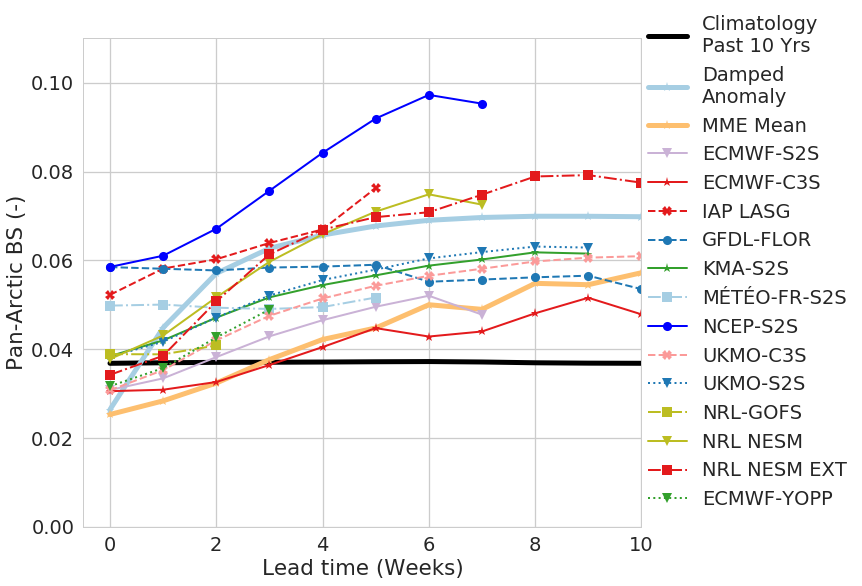

In [56]:
### Plot Brier Score vs lead time

min_N_samples = 10 # Min number of samples to allow for mean
BSS_agg_init = BSS_agg.mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.11]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)
print('savaing ',f_out)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


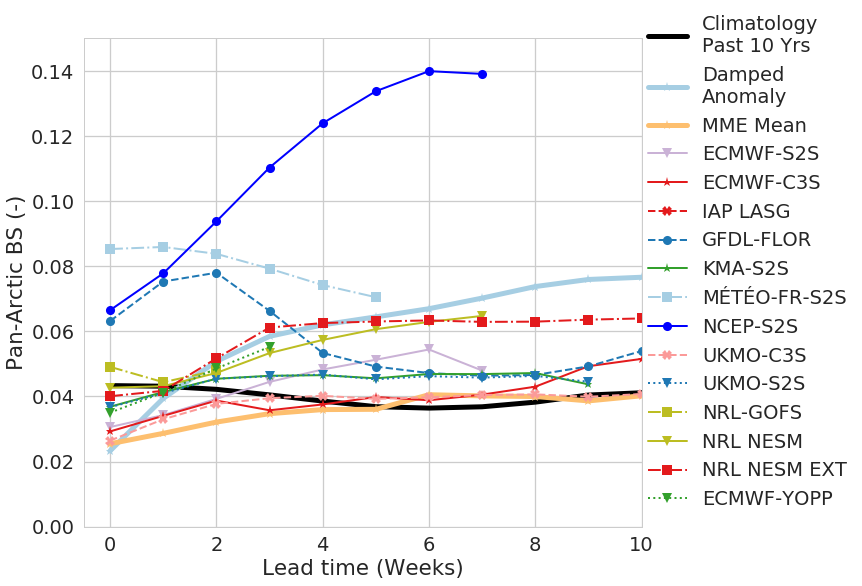

In [61]:
### Plot Brier Score vs lead time Summer Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2018-06-06','2018-09-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_JJAS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


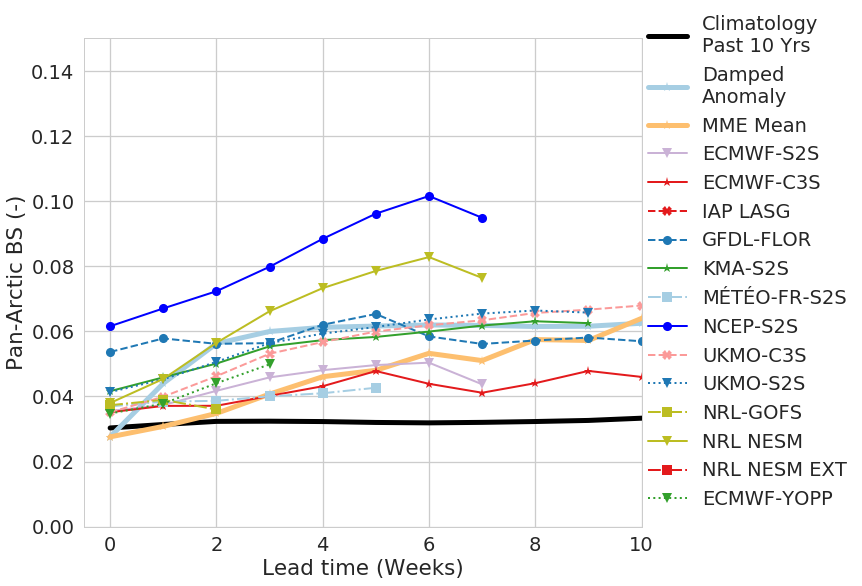

In [63]:
### Plot Brier Score vs lead time Winter Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2018-11-06','2019-04-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_NDJFM_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


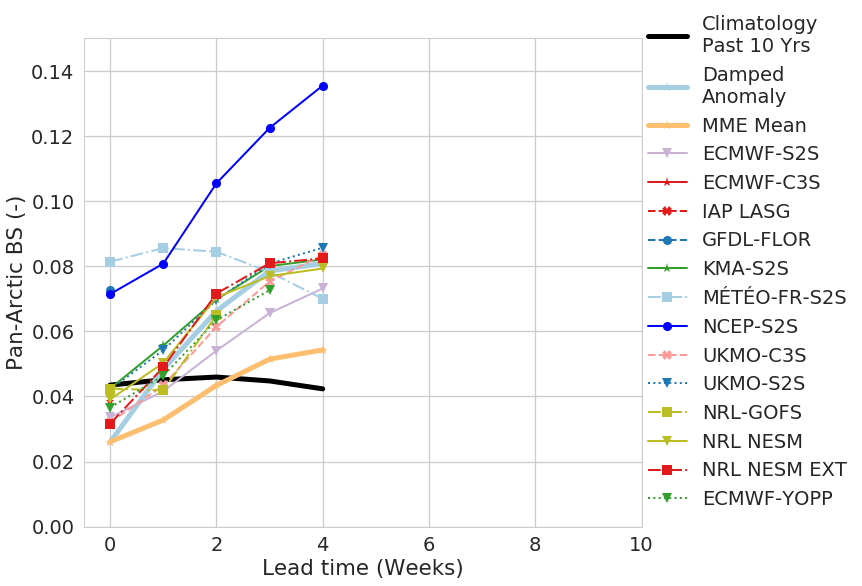

In [62]:
### Plot Brier Score vs lead time Summer Months
BSS_agg_init = BSS_agg.sel(init_end=slice('2019-06-06','2019-09-01')).mean(dim='init_end')
sns.set_style("whitegrid")

sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Get sample size of for each lead time
for_sample = BSS_agg.sel(model='MME').notnull().sum(dim='init_end')
for_sample

# Use threshold of sample size to cut off lead times
max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

f = plt.figure(figsize=(10,10))
NM = 10
ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)

for cmod in model_plot_order:
#for cmod in ['climatology']:
    if cmod in exl_mods:
        continue
    # Get model plotting specs
    cc = E.model_color[cmod]
    cl = E.model_linestyle[cmod]
    cm = E.model_marker[cmod]
    if cmod=='rasmesrl':
        cflag = '*'
    else:
        cflag = ''

    if cmod in ['MME','dampedAnomalyTrend','climatology','climo10yrs']:
        lw = 5
    else:
        lw = 2

    ax1.plot(BSS_agg_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
            BSS_agg_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
            color=cc,
            linestyle=cl,
            linewidth=lw,
            marker=cm)
    
ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
ax1.set_ylabel('Pan-Arctic BS (-)')
ax1.set_xlabel('Lead time (Weeks)')

ax1.set_ylim([0,0.15]);
ax1.set_xlim([-0.5,10]);
ax1.set_xticks(np.arange(0,11,2));

# Save to file
f_out = os.path.join(fig_dir,fig_ext+'BSS_2019JJAS_by_lead_time_PanArctic.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)

In [ ]:
  
    

    ### Plot the IIEE with lead time (SI)

    SIP_IIEE.load()

    min_N_samples = 10 # Min number of samples to allow for mean
    SIP_IIEE_init = SIP_IIEE.mean(dim='init_end')
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

    # Get sample size of for each lead time
    for_sample = SIP_IIEE.sel(model='MME').notnull().sum(dim='init_end')

    # Use threshold of sample size to cut off lead times
    max_lead = for_sample.where(for_sample>=min_N_samples,drop=True).fore_time.max().values.astype('timedelta64[D]').astype(int)/7

    f = plt.figure(figsize=(10,10))
    NM = 10
    ax1 = plt.subplot2grid((NM, NM), (0, 0), colspan=NM, rowspan=NM-1)
    ax2 = plt.subplot2grid((NM, NM), (NM-1, 0), colspan=NM, rowspan=1)

    for cmod in model_plot_order:
        if cmod in exl_mods:
            continue
        # Get model plotting specs
        cc = E.model_color[cmod]
        cl = E.model_linestyle[cmod]
        cm = E.model_marker[cmod]
        if cmod=='rasmesrl':
            cflag = '*'
        else:
            cflag = ''
        if cmod in ['MME','dampedAnomalyTrend','climatology']:
            lw=5
        else:
            lw = 2

        ax1.plot(SIP_IIEE_init.fore_time.values.astype('timedelta64[D]').astype(int)/7,
                SIP_IIEE_init.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*')+cflag,
                color=cc,
                linestyle=cl,
                linewidth=lw,
                marker=cm)
    ax1.legend(loc='lower right', bbox_to_anchor=(1.4, 0))
    ax1.set_ylabel('IIEE (Millions of km$^2$)')
    ax1.set_xlim([-0.5,max_lead])
    ax1.set_xticklabels([''])

    # second axis
    ax2.plot(for_sample.fore_time.values.astype('timedelta64[D]').astype(int)/7,
             for_sample.values, '-ko')
    ax2.set_ylabel('#\nweeks')
    ax2.set_xlabel('Lead time (Weeks)')
    ax2.set_xlim(ax1.get_xlim());

    ax2.set_ylim([0,for_sample.max()+5]);
    ax2.set_yticks(np.arange(0,for_sample.max()+5,15));

    if not PaperPlots: # only add for website plots
#        ax1.text(np.datetime64('2018-01-01'), 0.025, 'Wayand et al. (in review)', fontsize=12)
        ax1.text(7, 0.25, 'Wayand et al. (2019)', fontsize=12)


    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'IIEE_by_lead_time_PanArctic.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)







    ### Define DA methods for each model

    # copy past info from Table 1
    DA_dict = {
    'modcansipns_3':'SIC (NG)', 
    'modcansipns_4':'SIC (NG)',
    'ecmwfsipn':'SIC (3DVAR)', 
    'ecmwf':'SIC (3DVAR)',
    'yopp':'SIC (3DVAR)',
    'gfdlsipn':'No Sea Ice DA',
    'metreofr':'SIC (EnKF)',
    'szapirosipn':'No Sea Ice DA',
    'ncep-exp-bias-corr':'SIC (NG)',
    'noaasipn':'SIC (NG)',
    'usnavysipn':'SIC (3DVAR)',
    'usnavyncep':'SIC (3DVAR)',
    'usnavygofs':'SIC (3DVAR)',
    'rasmesrl':'SIC (DI), SIT* (DI)',
    'uclsipn':'No Sea Ice DA',
    'ukmetofficesipn':'SIC (3DVAR)',
    'ukmo':'SIC (3DVAR)',
    'ncep':'SIC (NG)',
    'kma':'SIC (3DVAR)'
    }

    # Add models
    DA_dict['climatology'] = 'No Sea Ice DA'
    DA_dict['dampedAnomalyTrend'] = 'SIC (DI)'
    DA_dict['MME'] = 'MME'
    DA_dict

    DA_options = sorted(list(set(DA_dict.values())))
    dict(zip(DA_options,np.arange(len(DA_options))))

    #DA_options = [DA_options[1],  DA_options[4], DA_options[5], DA_options[7], DA_options[2], DA_options[3], DA_options[6],DA_options[0],] # Reorder from simple to complex
    DA_options = [DA_options[1],  DA_options[3], DA_options[4], DA_options[6], DA_options[2], DA_options[5],DA_options[0],] # Reorder from simple to complex
    
    DA_options_i = np.arange(len(DA_options))
    DA_options_dict = dict(zip(DA_options,DA_options_i))
    DA_options_dict

    ### Plot BS by DA method (Figure 4)

    # In place a multi lead times

    # Lead times to plot
    leads2plot = [0,1,2,3,4] # indices
    sns.set_style("whitegrid")

    sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 2.5})
    f, axes = plt.subplots(1, 1, figsize=(9, 5))

    for cmod in BSS_agg.model.values:
        if cmod in DA_dict.keys():
            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]
            cm = E.model_marker[cmod]
            if cmod=='MME':
                lw=4
            else:
                lw=2

            BSS_init = BSS_agg.sel(model=cmod).isel(fore_time=leads2plot).mean(dim='init_end').load()

            #rand_jit = np.random.randint(-100,100)/1000*2
            c_x = np.linspace(DA_options_dict[DA_dict[cmod]],
                              DA_options_dict[DA_dict[cmod]]+0.75,
                              len(leads2plot))
            #print(c_x)

            axes.plot(c_x, 
                    BSS_init.values,
                    color=cc,
                    linestyle='-',
                    linewidth=lw,
                    marker=cm,
                    label=E.model[cmod]['model_label'].rstrip('*'))
        else:
            print(cmod,"not in dict")
    axes.set_xticks(DA_options_i)
    axes.set_xticklabels(DA_options, rotation='45', ha='right')

    plt.legend(loc='lower right', bbox_to_anchor=(1.36, -.25))
    plt.ylabel('Pan-Arctic BS (-)')

    if not PaperPlots: # only add for website plots
        axes.text(4.2, 0.081, 'Based on Wayand et al. (2019)', fontsize=12)

    # Save to file
    f_out = os.path.join(fig_dir,fig_ext+'BSS_week_Multi_by_DA_Type.png')
    f.savefig(f_out,bbox_inches='tight', dpi=200)



    ### Plot BS by initialization time (Figure 2)

    sns.set_style("whitegrid")

    for ft_i in [4]:
        BSS_agg_fore = BSS_agg.isel(fore_time=ft_i)

        sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
        f = plt.figure(figsize=(10,10))
        for cmod in model_plot_order:
            # Get model plotting specs
            cc = E.model_color[cmod]
            cl = E.model_linestyle[cmod]
            cm = E.model_marker[cmod]
            if cmod in ['MME','dampedAnomalyTrend','climatology']:
                lw=5
            else:
                lw = 2
            if BSS_agg_fore.sel(model=cmod).notnull().sum().values==0:
                continue # Don't plot
            plt.plot(BSS_agg_fore.init_end.values,
                    BSS_agg_fore.sel(model=cmod).values, label=E.model[cmod]['model_label'].rstrip('*'),
                    color=cc,
                    linestyle=cl,
                    linewidth=lw,
                    marker=cm)
        plt.legend(loc='lower right', bbox_to_anchor=(1.4, -0.1))
        plt.ylabel('Pan-Arctic BS (-)')
        plt.xlabel('Initialization date')
        #plt.title(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))
        f.autofmt_xdate()


        if not PaperPlots: # only add for website plots
            plt.text(np.datetime64('2018-01-01'), 0.163, 'Based on Wayand et al. (2019)', fontsize=12)
        # Save to file
        f_out = os.path.join(fig_dir,fig_ext+'BSS_by_init_time_'+str(BSS_agg_fore.fore_time.values.astype('timedelta64[D]').astype(int))+'_days.png')
        f.savefig(f_out,bbox_inches='tight', dpi=200)

        print("Finished Eval_Weekly")

In [ ]:
if __name__ == '__main__':
    # Start up Client
    client = Client(n_workers=8)
    
    # Call function
    Update_Evaluation_Maps(PaperPlots)

In [ ]:
PaperPlots